## England Premier League

## Notes for Football Data

Key to results data:

Div = League Division
Date = Match Date (dd/mm/yy)
HomeTeam = Home Team
AwayTeam = Away Team
FTHG and HG = Full Time Home Team Goals
FTAG and AG = Full Time Away Team Goals
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
HTHG = Half Time Home Team Goals
HTAG = Half Time Away Team Goals
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

Match Statistics (where available)
Attendance = Crowd Attendance
Referee = Match Referee
HS = Home Team Shots
AS = Away Team Shots
HST = Home Team Shots on Target
AST = Away Team Shots on Target
HHW = Home Team Hit Woodwork
AHW = Away Team Hit Woodwork
HC = Home Team Corners
AC = Away Team Corners
HF = Home Team Fouls Committed
AF = Away Team Fouls Committed
HFKC = Home Team Free Kicks Conceded
AFKC = Away Team Free Kicks Conceded
HO = Home Team Offsides
AO = Away Team Offsides
HY = Home Team Yellow Cards
AY = Away Team Yellow Cards
HR = Home Team Red Cards
AR = Away Team Red Cards
HBP = Home Team Bookings Points (10 = yellow, 25 = red)
ABP = Away Team Bookings Points (10 = yellow, 25 = red)

Note that Free Kicks Conceeded includes fouls, offsides and any other offense commmitted and will always be equal to or higher than the number of fouls. Fouls make up the vast majority of Free Kicks Conceded. Free Kicks Conceded are shown when specific data on Fouls are not available (France 2nd, Belgium 1st and Greece 1st divisions).

Note also that English and Scottish yellow cards do not include the initial yellow card when a second is shown to a player converting it into a red, but this is included as a yellow (plus red) for European games.


Key to 1X2 (match) betting odds data:

B365H = Bet365 home win odds
B365D = Bet365 draw odds
B365A = Bet365 away win odds
BSH = Blue Square home win odds
BSD = Blue Square draw odds
BSA = Blue Square away win odds
BWH = Bet&Win home win odds
BWD = Bet&Win draw odds
BWA = Bet&Win away win odds
GBH = Gamebookers home win odds
GBD = Gamebookers draw odds
GBA = Gamebookers away win odds
IWH = Interwetten home win odds
IWD = Interwetten draw odds
IWA = Interwetten away win odds
LBH = Ladbrokes home win odds
LBD = Ladbrokes draw odds
LBA = Ladbrokes away win odds
PSH and PH = Pinnacle home win odds
PSD and PD = Pinnacle draw odds
PSA and PA = Pinnacle away win odds
SOH = Sporting Odds home win odds
SOD = Sporting Odds draw odds
SOA = Sporting Odds away win odds
SBH = Sportingbet home win odds
SBD = Sportingbet draw odds
SBA = Sportingbet away win odds
SJH = Stan James home win odds
SJD = Stan James draw odds
SJA = Stan James away win odds
SYH = Stanleybet home win odds
SYD = Stanleybet draw odds
SYA = Stanleybet away win odds
VCH = VC Bet home win odds
VCD = VC Bet draw odds
VCA = VC Bet away win odds
WHH = William Hill home win odds
WHD = William Hill draw odds
WHA = William Hill away win odds

Bb1X2 = Number of BetBrain bookmakers used to calculate match odds averages and maximums
BbMxH = Betbrain maximum home win odds
BbAvH = Betbrain average home win odds
BbMxD = Betbrain maximum draw odds
BbAvD = Betbrain average draw win odds
BbMxA = Betbrain maximum away win odds
BbAvA = Betbrain average away win odds

MaxH = Oddsportal maximum home win odds
MaxD = Oddsportal maximum draw win odds
MaxA = Oddsportal maximum away win odds
AvgH = Oddsportal average home win odds
AvgD = Oddsportal average draw win odds
AvgA = Oddsportal average away win odds



Key to total goals betting odds:

BbOU = Number of BetBrain bookmakers used to calculate over/under 2.5 goals (total goals) averages and maximums
BbMx>2.5 = Betbrain maximum over 2.5 goals
BbAv>2.5 = Betbrain average over 2.5 goals
BbMx<2.5 = Betbrain maximum under 2.5 goals
BbAv<2.5 = Betbrain average under 2.5 goals

GB>2.5 = Gamebookers over 2.5 goals
GB<2.5 = Gamebookers under 2.5 goals
B365>2.5 = Bet365 over 2.5 goals
B365<2.5 = Bet365 under 2.5 goals


Key to Asian handicap betting odds:

BbAH = Number of BetBrain bookmakers used to Asian handicap averages and maximums
BbAHh = Betbrain size of handicap (home team)
BbMxAHH = Betbrain maximum Asian handicap home team odds
BbAvAHH = Betbrain average Asian handicap home team odds
BbMxAHA = Betbrain maximum Asian handicap away team odds
BbAvAHA = Betbrain average Asian handicap away team odds

GBAHH = Gamebookers Asian handicap home team odds
GBAHA = Gamebookers Asian handicap away team odds
GBAH = Gamebookers size of handicap (home team)
LBAHH = Ladbrokes Asian handicap home team odds
LBAHA = Ladbrokes Asian handicap away team odds
LBAH = Ladbrokes size of handicap (home team)
B365AHH = Bet365 Asian handicap home team odds
B365AHA = Bet365 Asian handicap away team odds
B365AH = Bet365 size of handicap (home team)


Closing odds (last odds before match starts)

PSCH = Pinnacle closing home win odds
PSCD = Pinnacle closing draw odds
PSCA = Pinnacle closing away win odds

Football-Data would like to acknowledge the following sources which have been utilised in the compilation of Football-Data's results and odds files.


Current results (full time, half time)
Xcores - http://www.xcores .com

Match statistics
Sportinglife, ESPN Soccer, Bundesliga.de, Gazzetta.it and Football.fr

Bookmakers betting odds
Betbrain - http://www.betbrain.com
Oddsportal - http://www.oddsportal.com
Individual bookmakers

Betting odds for weekend games are collected Friday afternoons, and on Tuesday afternoons for midweek games.


In [2]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from sklearn.preprocessing import LabelEncoder

In [3]:
#read_files = glob.glob("./data/*.csv")
#print(read_files)
df_list = []
for file in glob.glob('./data/*.csv'):
    season = int(file[19:23])
#    print(season)
    games = (pd.read_csv(file)).assign(Season=season)
    df_list.append(games)

games = pd.concat(df_list, sort=False)


In [4]:
games.head(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,Unnamed: 27,GBAHH,GBAHA,GBAH,LBAHH,LBAHA,LBAH,B365AHH,B365AHA,B365AH
0,E0,16/08/14,Arsenal,Crystal Palace,2.0,1.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,16/08/14,Leicester,Everton,2.0,2.0,D,1.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,16/08/14,Man United,Swansea,1.0,2.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,16/08/14,QPR,Hull,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,16/08/14,Stoke,Aston Villa,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

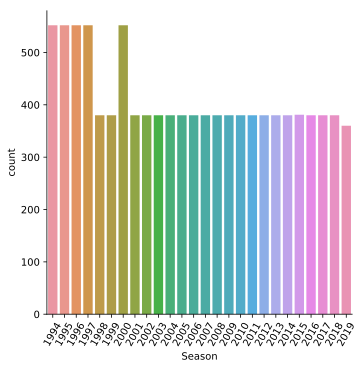

In [5]:
sns.catplot(x="Season", kind="count", data=games);
plt.xticks(rotation=60)

## Количество игр выигранных дома, на выезде и ничья

Из графика видно, что количество выигранных домашних игр больше, чем на выезде.

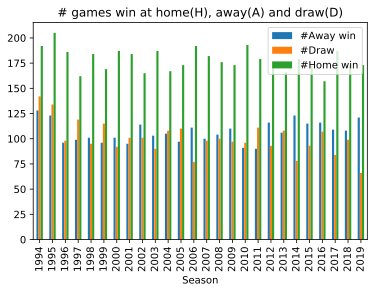

In [14]:
by_season_ftr = games.groupby(["Season", "FTR"])
count_by_season_ftr = by_season_ftr['FTHG'].aggregate('count').unstack()
ax = count_by_season_ftr.plot(kind = 'bar', title = '# games win at home(H), away(A) and draw(D)')
ax.legend(['#Away win', '#Draw', '#Home win'])
plt.show()
#title = ‘ by Regiment, Bucket’
#by_season_ftr = dict(list(games.groupby(["Season", "FTR"])))

## Качество предсказания исхода матча (букмейкер Interwetten) 

Рассмотрен букмейкер Interwetten, так как у него больше истории.

Исходные данные:
FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)

Коэффициенты матчей:
IWH = Interwetten home win odds
IWD = Interwetten draw odds
IWA = Interwetten away win odds

Оценка качества предсказания букмейкера:
min('IWH', 'IWD', 'IWA')  - наиболее вероятное событие. Если это событие произошло, то Quality_pred = true, если не произошло, то Quality_pred = false.

То есть в итоге будет добавлен столбец с качеством предсказания исхода матча букмейкером. Просуммировав количество удачных и неудачных предсказаний, мы поймем насколько точен букмейкер.



/home/ilya/anaconda3/envs/otus-ds/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


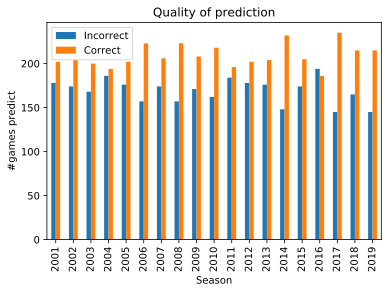

In [15]:
games_pure_bet = games.dropna(subset=['FTR', 'IWH', 'IWD', 'IWA'])
#games_pure_bet = games.dropna(subset=['FTR', 'PSCH', 'PSCD', 'PSCA'])


def bookmaker_predict_IW(odd_h, odd_d, odd_a, ftr):
    min_odd = min(odd_h, odd_d, odd_a)
    if (ftr == 'H'):
        return (min_odd == odd_h)
    elif (ftr == 'D'):
        return (min_odd == odd_d)
    elif (ftr == 'A'):
        return (min_odd == odd_a)

games_pure_bet['Quality_pred'] = games_pure_bet.apply(
    lambda row: bookmaker_predict_IW(row['IWH'], row['IWD'], row['IWA'], row['FTR']), axis=1)


by_season_quality_pred = games_pure_bet.groupby(["Season", "Quality_pred"])
count_by_season_quality_pred = by_season_quality_pred['FTHG'].aggregate('count').unstack()
ax = count_by_season_quality_pred.plot(kind = 'bar', title = 'Quality of prediction' )
ax.set_ylabel("#games predict")
ax.legend(["Incorrect", "Correct"]);
plt.show()


## 1. Проверка стратегии ставок - ставим на минимальную ставку в каждой игре

1. Ставим 100 usd на каждую игру с 2001 по 2019 год.
Ставку делаем на самое вероятное событие по версии букмейкера - Interwetten, т.е. делаем на ставку на min('IWH', 'IWD', 'IWA').

Коэффициенты матчей:
IWH = Interwetten home win odds
IWD = Interwetten draw odds
IWA = Interwetten away win odds

2. Добавим столбец Profit в датасет расчитанный следующим образом:
Если результат матча = Событие(min('IWH', 'IWD', 'IWA')), 
тогда Profit = 100* min('IWH', 'IWD', 'IWA')

Если результат матча != Событие(min('IWH', 'IWD', 'IWA')), 
тогда Profit = -100

3. Рассчитаем сумму выигрыша за каждый сезон и составим кумулятивные суммы для каждого сезона (чтобы оценить насколько такая стратегия может выходит в минус)



In [29]:
bet = 100
comission = 0.1

def profit_IW(odd_h, odd_d, odd_a, quality_pred):
    min_odd = min(odd_h, odd_d, odd_a)
    if (quality_pred==True):
        return min_odd*bet-bet
    else:
        return (-1) * bet   
    
games_pure_bet['Profit'] = games_pure_bet.apply(
#    lambda row: profit_IW(row['IWH'], row['IWD'], row['IWHA'], row['Quality_pred']), axis=1)
    lambda row: profit_IW(row['IWH'], row['IWD'], row['IWA'], row['Quality_pred']), axis=1)



/home/ilya/anaconda3/envs/otus-ds/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [30]:
by_season = games_pure_bet.groupby(["Season"])
profit_by_season = by_season['Profit'].aggregate('sum')

## Суммарная прибыль за сезон

In [33]:
profit_by_season

Season
2001   -1315.0
2002   -1170.0
2003    -210.0
2004   -2466.0
2005    -855.0
2006    2452.0
2007    -837.0
2008    1311.0
2009    -711.0
2010    -187.0
2011   -2183.0
2012   -2585.0
2013   -2060.0
2014    2975.0
2015    -995.0
2016   -3053.0
2017    3646.0
2018      76.0
2019     993.0
Name: Profit, dtype: float64

## Кумулятивные суммы прибыли для каждого сезона

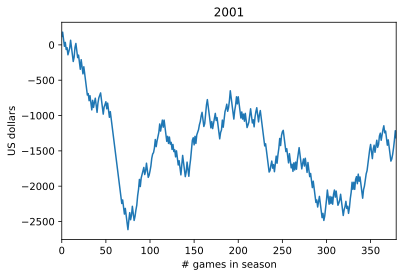

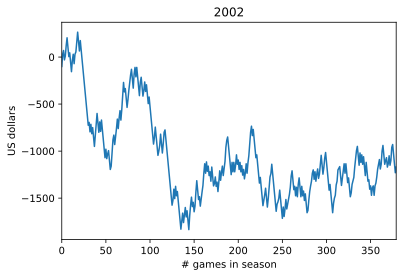

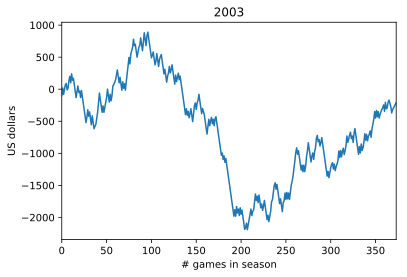

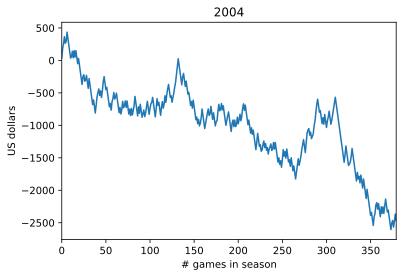

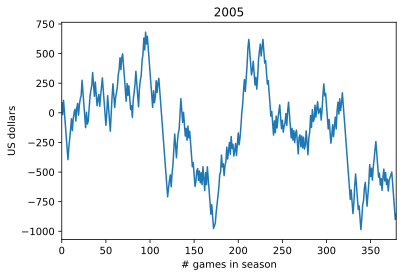

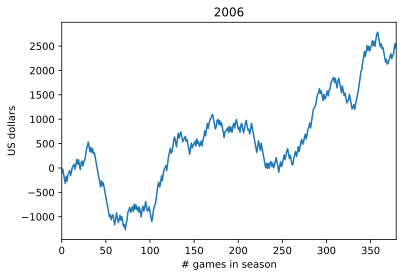

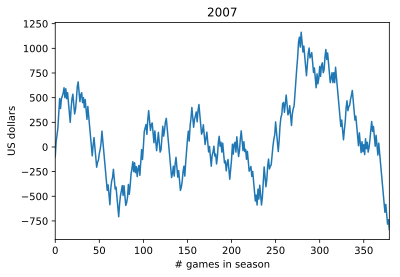

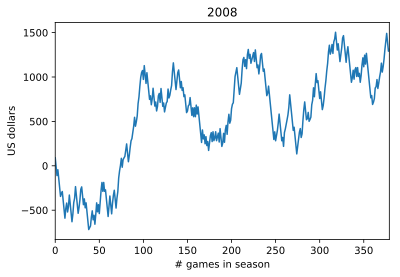

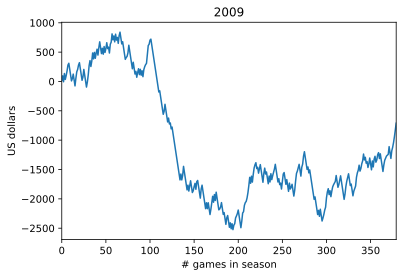

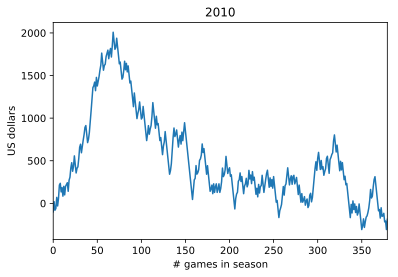

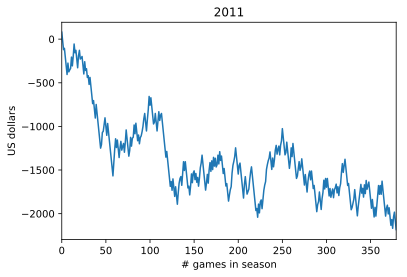

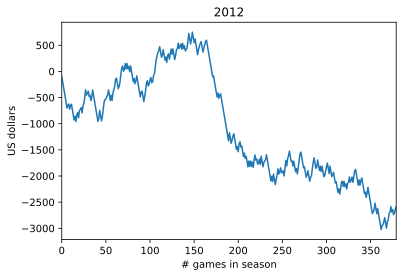

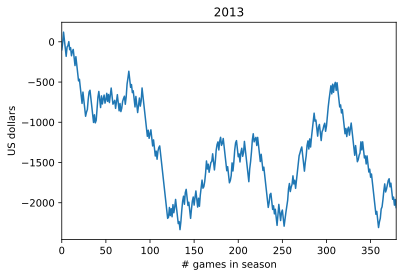

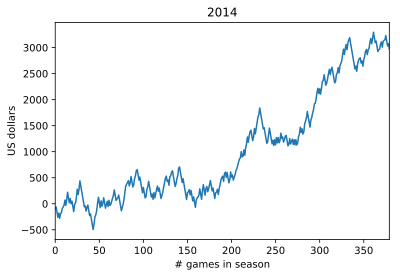

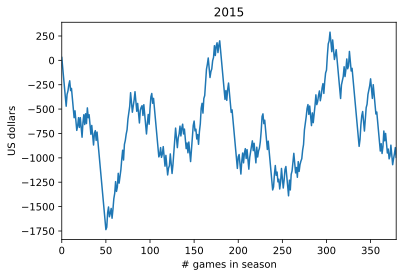

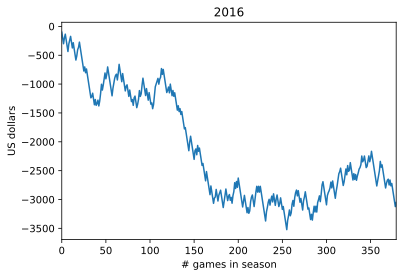

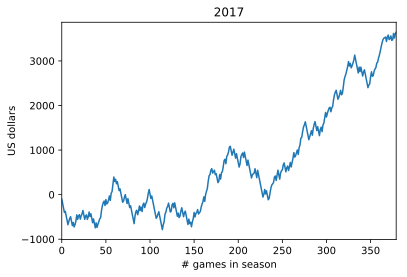

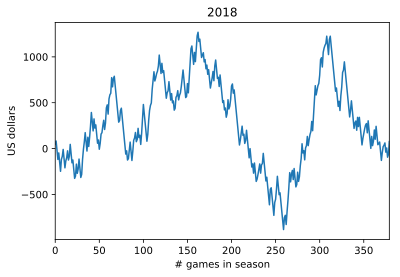

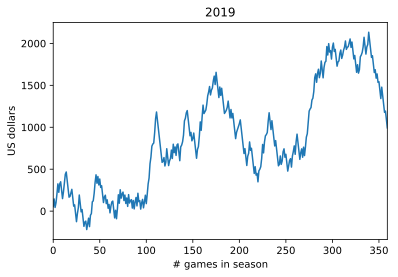

In [34]:
for season in range(2001,2020,1):
    plt.figure(season)
    ax = games_pure_bet[games_pure_bet["Season"] == season]['Profit'].cumsum().plot(title = season)
    ax.set_ylabel("US dollars")
    ax.set_xlabel("# games in season")

## 2. Проверка стратегии - ставим на максимальную ставку в каждой игре

In [43]:
bet = 100
comission = 0.1
   
def profit_IW_max(odd_h, odd_d, odd_a, ftr):
    max_odd = max(odd_h, odd_d, odd_a)
    if ((max_odd == odd_h) & (ftr == 'H')):
        return max_odd*bet - bet
    elif ((max_odd == odd_d) & (ftr == 'D')):
        return max_odd*bet - bet
    elif ((max_odd == odd_a) & (ftr == 'A')):
        return max_odd*bet - bet
    else:
        return (-1)*bet
    
games_pure_bet['Profit_max'] = games_pure_bet.apply(
#    lambda row: profit_IW(row['IWH'], row['IWD'], row['IWHA'], row['Quality_pred']), axis=1)
    lambda row: profit_IW_max(row['IWH'], row['IWD'], row['IWA'], row['FTR']), axis=1)

/home/ilya/anaconda3/envs/otus-ds/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
games_pure_bet.head(20)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,LBAHH,LBAHA,LBAH,B365AHH,B365AHA,B365AH,Quality_pred,Profit,Profit-max,Profit_max
0,E0,16/08/14,Arsenal,Crystal Palace,2.0,1.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,True,30.0,810.0,-100.0
1,E0,16/08/14,Leicester,Everton,2.0,2.0,D,1.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,False,-100.0,-100.0,230.0
2,E0,16/08/14,Man United,Swansea,1.0,2.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,False,-100.0,-100.0,700.0
3,E0,16/08/14,QPR,Hull,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,False,-100.0,-100.0,-100.0
4,E0,16/08/14,Stoke,Aston Villa,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,False,-100.0,-100.0,260.0
5,E0,16/08/14,West Brom,Sunderland,2.0,2.0,D,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,False,-100.0,-100.0,230.0
6,E0,16/08/14,West Ham,Tottenham,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,True,120.0,297.0,-100.0
7,E0,17/08/14,Liverpool,Southampton,2.0,1.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,True,35.0,684.0,-100.0
8,E0,17/08/14,Newcastle,Man City,0.0,2.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,True,65.0,441.0,-100.0
9,E0,18/08/14,Burnley,Chelsea,1.0,3.0,A,1.0,3.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,True,40.0,612.0,-100.0


In [45]:
by_season_max = games_pure_bet.groupby(["Season"])
profit_max_by_season = by_season['Profit_max'].aggregate('sum')

In [46]:
profit_max_by_season

Season
2001    -7030.0
2002    -5300.0
2003    -8130.0
2004    -6110.0
2005   -12280.0
2006   -12100.0
2007    -6010.0
2008   -14650.0
2009    -8725.0
2010    -6020.0
2011      235.0
2012      225.0
2013    -1970.0
2014      510.0
2015     2055.0
2016     4880.0
2017    -9000.0
2018    -1285.0
2019    -4065.0
Name: Profit_max, dtype: float64

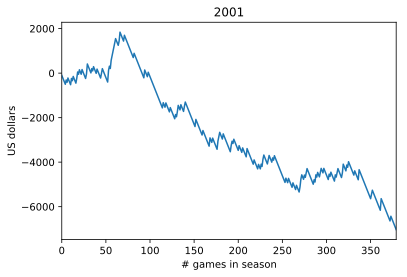

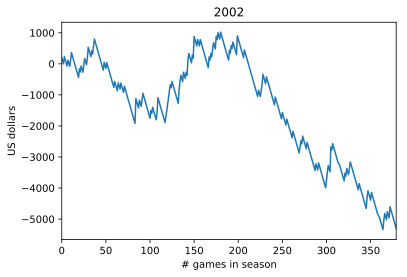

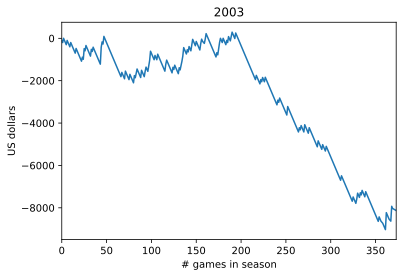

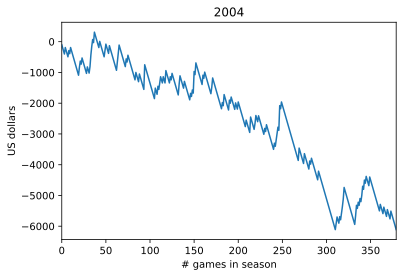

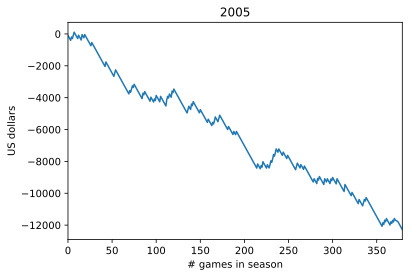

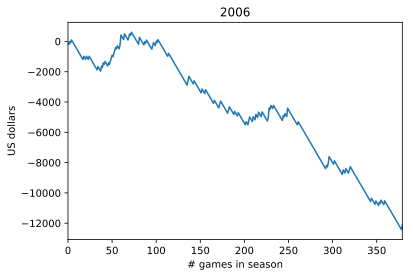

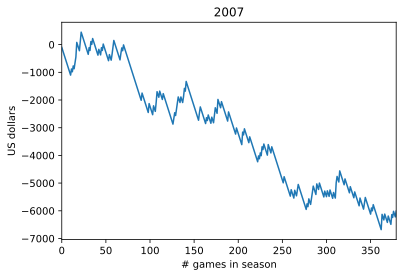

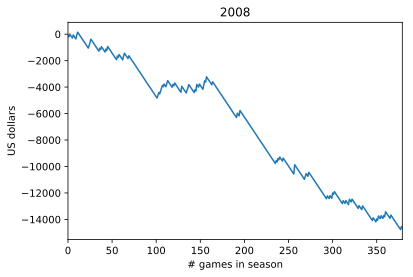

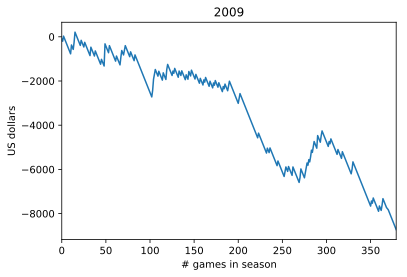

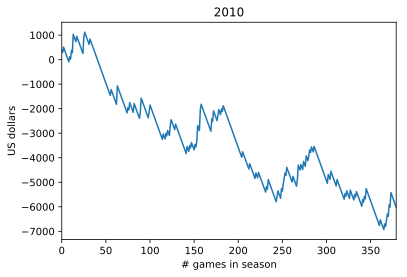

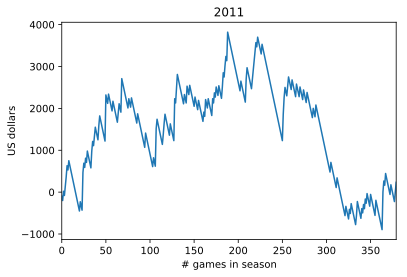

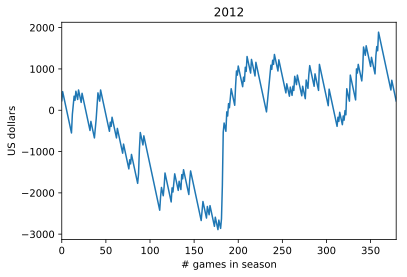

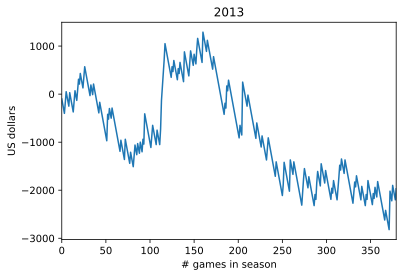

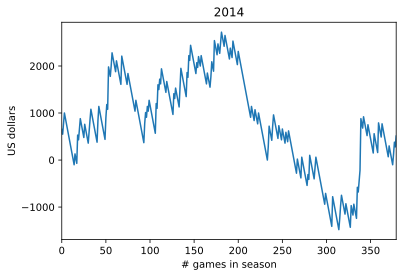

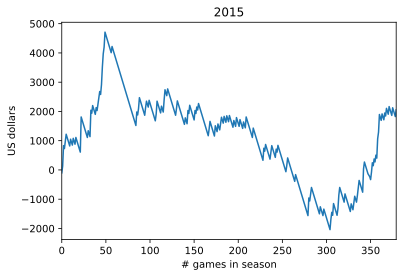

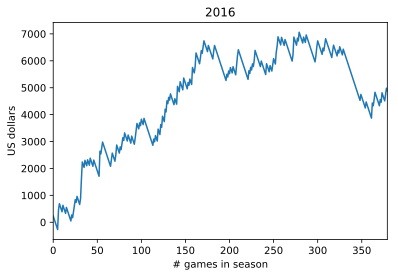

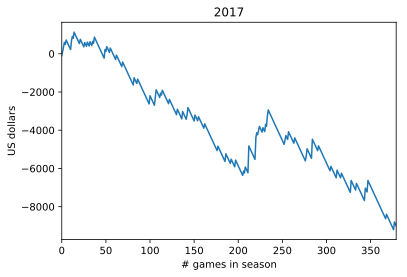

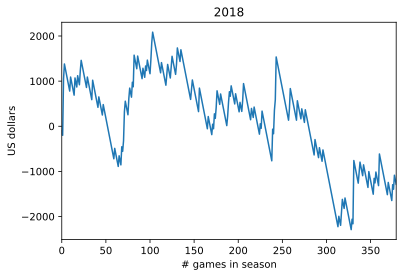

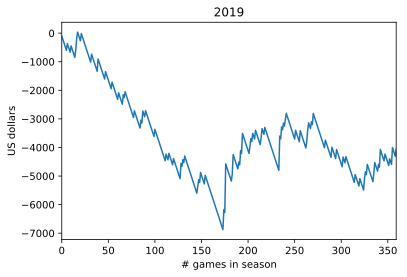

In [48]:
for season in range(2001,2020,1):
    plt.figure(season)
    ax = games_pure_bet[games_pure_bet["Season"] == season]['Profit_max'].cumsum().plot(title = season)
    ax.set_ylabel("US dollars")
    ax.set_xlabel("# games in season")